<h2>Generating example datasets</h2>

This notebook describes the generation of example datasets for the photometric redshift problem using public survey data. We highlight issues such as missing data and spectroscopic incomplteness.

In [2]:
from astropy.table import Table
import numpy as np
%matplotlib inline

import matplotlib.pylab as plt

almost_black = '#262626'
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams.update({'font.size': 20, 
                     'axes.linewidth': 5,
                    'text.color': almost_black,
                    'xtick.major.size': 4,
                    'ytick.major.size': 4,
                    'legend.fancybox': True,
                    'figure.dpi': 300,
                    'legend.fontsize': 20,
                    'legend.framealpha': 0.8,
                    'legend.shadow': True,
                    'xtick.labelsize': 20,
                    'ytick.labelsize': 20})
col = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'black']

path = ''

np.random.seed(32)

<h2>SDSS data</h2>

We run this query within http://casjobs.sdss.org/ on the Data Release 13 scheme

""" SELECT top 200000 p.objId  as OBJID,
    p.ra as RA, p.dec as DEC,
    p.type as PHOTPTYPE,  dbo.fPhotoTypeN(p.type) as PHOT_SG,
  
    p.DERED_R, p.DERED_I, p.DERED_Z,
  
  
    p.CMODELFLUX_U, p.CMODELFLUXIVAR_U, p.CMODELFLUX_G,p.CMODELFLUXIVAR_G,
    p.CMODELFLUX_R, p.CMODELFLUXIVAR_R, p.CMODELFLUX_I,p.CMODELFLUXIVAR_I,
    p.CMODELFLUX_Z, p.CMODELFLUXIVAR_Z,

    p.PSFFLUX_U -p.EXTINCTION_U as PSFFLUX_U, p.PSFFLUXIVAR_U, 
    p.PSFFLUX_G -p.EXTINCTION_G as PSFFLUX_G, p.PSFFLUXIVAR_G, 
    p.PSFFLUX_R -p.EXTINCTION_R as PSFFLUX_R, p.PSFFLUXIVAR_R,
    p.PSFFLUX_I -p.EXTINCTION_I as PSFFLUX_I, p.PSFFLUXIVAR_I, 
    p.PSFFLUX_Z -p.EXTINCTION_Z as PSFFLUX_Z, p.PSFFLUXIVAR_Z, 
  
    p.FIBERFLUX_U -p.EXTINCTION_U as FIBERFLUX_U, p.FIBERFLUXIVAR_U,
    p.FIBERFLUX_G -p.EXTINCTION_G as FIBERFLUX_G, p.FIBERFLUXIVAR_G,
    p.FIBERFLUX_R -p.EXTINCTION_R as FIBERFLUX_R, p.FIBERFLUXIVAR_R, 
    p.FIBERFLUX_I -p.EXTINCTION_I as FIBERFLUX_I, p.FIBERFLUXIVAR_I,
    p.FIBERFLUX_Z -p.EXTINCTION_Z as FIBERFLUX_Z, p.FIBERFLUXIVAR_Z,

    p.FRACDEV_R,
    p.EXPRAD_R, p.EXPRADERR_R,
    p.PETROR50_R, p.PETROR90_R,
    p.DEVRAD_R, p.DEVRADERR_R,
  
    
    ISNULL(s.z, -1) as SPEC_Z, ISNULL(s.zErr, -1) as SPEC_Z_ERR, 
    ISNULL(pz.z,-1) as PHOTOZ, ISNULL(pz.zerr,-1) as PHOTOZ_ERR,

    s.specObjID as SPECOBJID, ISNULL(s.class, -1) as SPEC_CLASS, ISNULL(s.subClass,-1) as SPEC_SUBCLASS 
    

    FROM SpecPhotoAll s 
    INTO mydb.SDSS_DR13_FRANKZ
      JOIN PhotoPrimary p ON  s.ObjID = p.ObjID and s.zWarning is not NULL and s.specObjID is not NULL and p.type=3 and  s.ObjID is not NULL
      and s.zWarning=0
    JOIN PHOTOZ pz ON s.ObjID = pz.ObjID """
    
We next post-process this data, into an incomplete, clean training dataset, and a complete (stellar contaminated testing test)

In [3]:
#this original file is downloadable from 
#http://129.187.203.185/~hoyleb/FRANKZ/
#add to data/ directory.
d = Table.read(path + 'data/SDSS_DR13_FRANKZ_hoyleb_0.fit.bz2')

In [4]:
#initial test data
dtest = d[0: len(d)/2]

#inital train data
dtrain = d[len(d)/2: ]

#free up some space
del d

<h4>Generate training and test data from this sample</h4>

In [5]:
#let's just use the best training data, by making some quality cuts
ind_train = np.array(dtrain['SPEC_Z'] > 1e-3) * np.array(dtrain['SPEC_Z_ERR'] < 1e-4) * np.array(
    [i.replace(' ','') == 'GALAXY' for i in dtrain['SPEC_CLASS']])
print('Initial -> clean training data size {:} -> {:}'.format(len(dtrain), np.sum(ind_train)))

dtrain = dtrain[ind_train]

#let's add a few magnitude, redshift cuts, at the 90% percentile of the test data
ind_biased = np.ones(len(dtrain), dtype=bool)
for i in ['DERED_R', 'DERED_I', 'DERED_Z', 'SPEC_Z']:
    ind_biased *= np.array(dtrain[i] < np.percentile(dtest[i], 90))

#let's add 10% of the biased sample back to the training data, to mimic a heterogeneous training sample
ind_remove = np.arange(len(dtrain))[~ind_biased]
rand_ind = np.random.choice(ind_remove, size=int(len(ind_remove)*0.1), replace=False)
ind_biased[rand_ind] = True

print('Initial -> clean & biased training data size {:} -> {:}'.format(len(dtrain), np.sum(ind_biased)))

#free up some space
dtrain = dtrain[ind_biased]

Initial -> clean training data size 100000 -> 60668
Initial -> clean & biased training data size 60668 -> 59132


<h4>Visualise the training/test sample biases</h4>

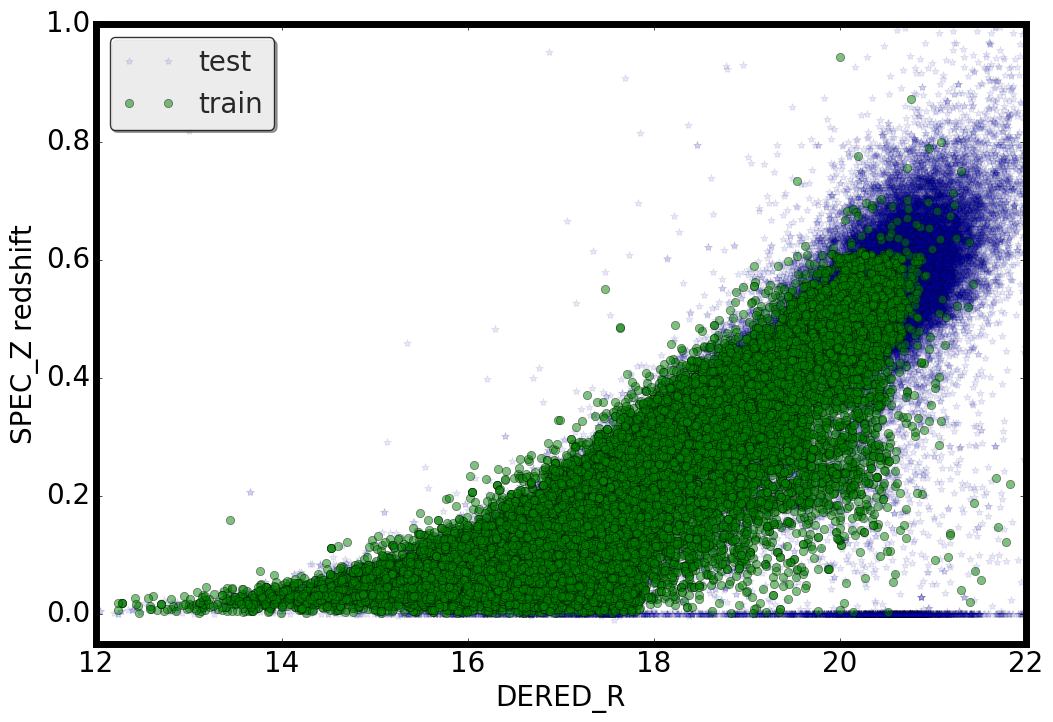

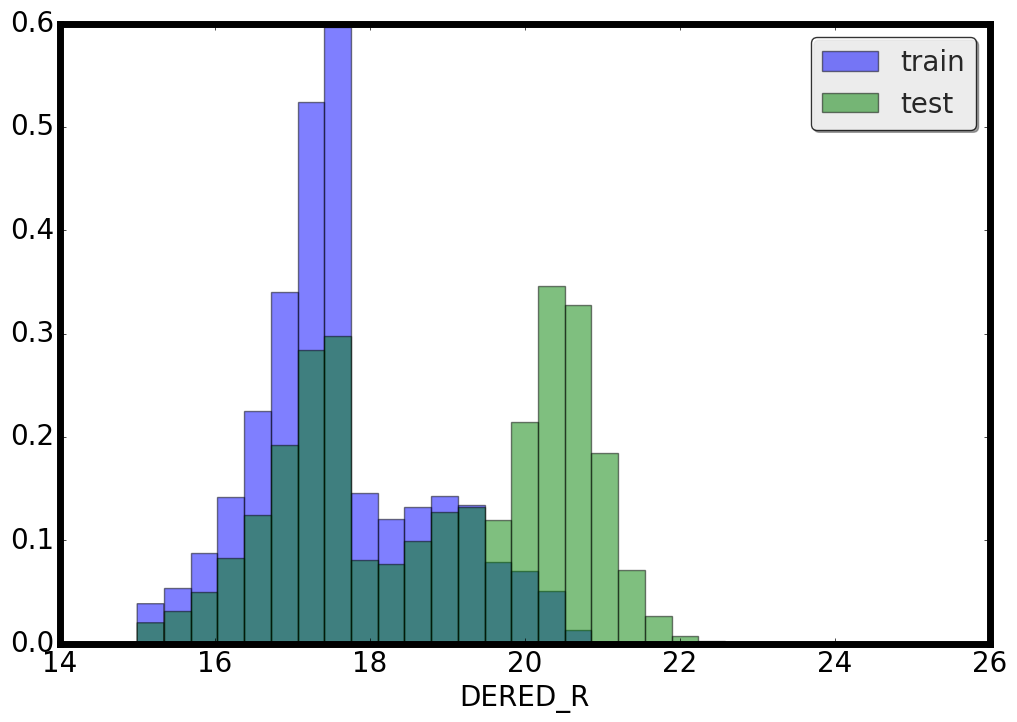

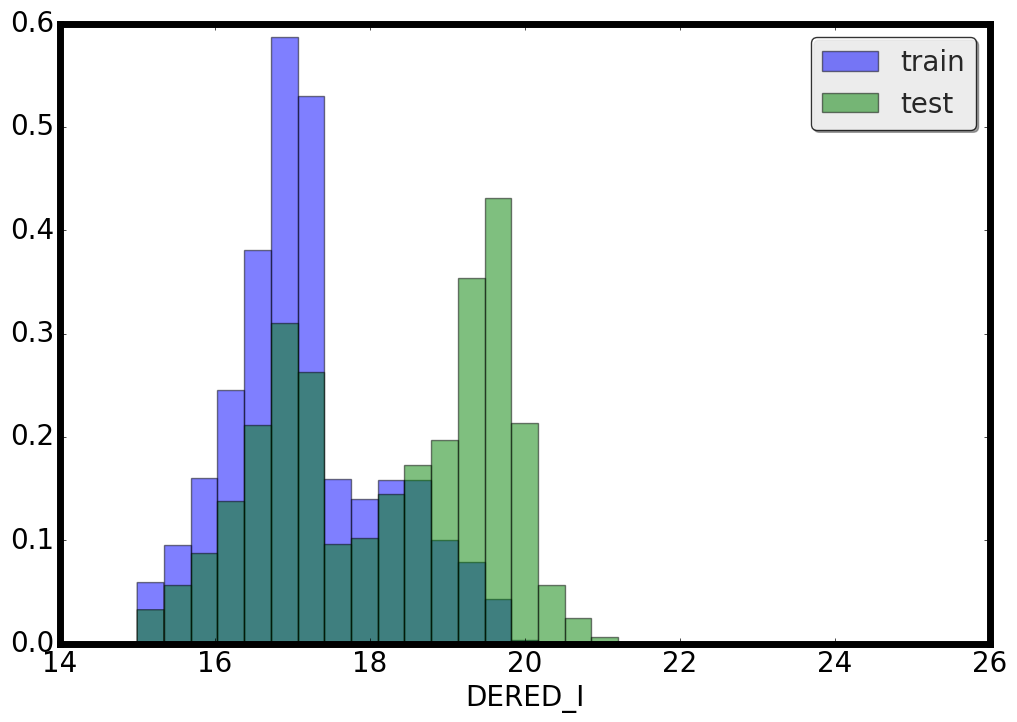

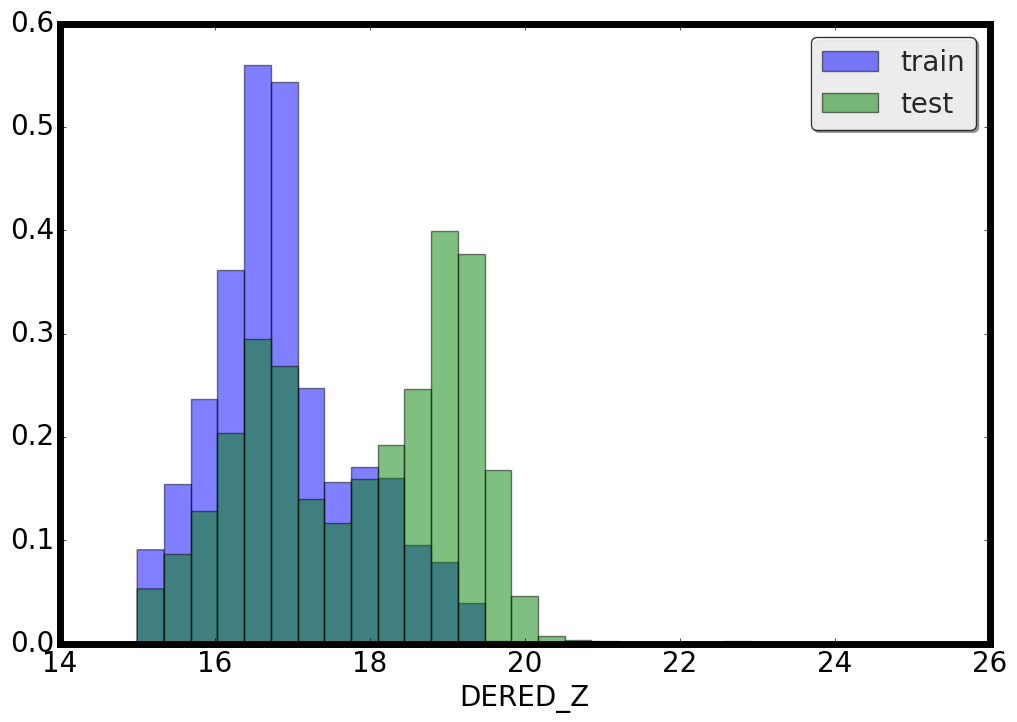

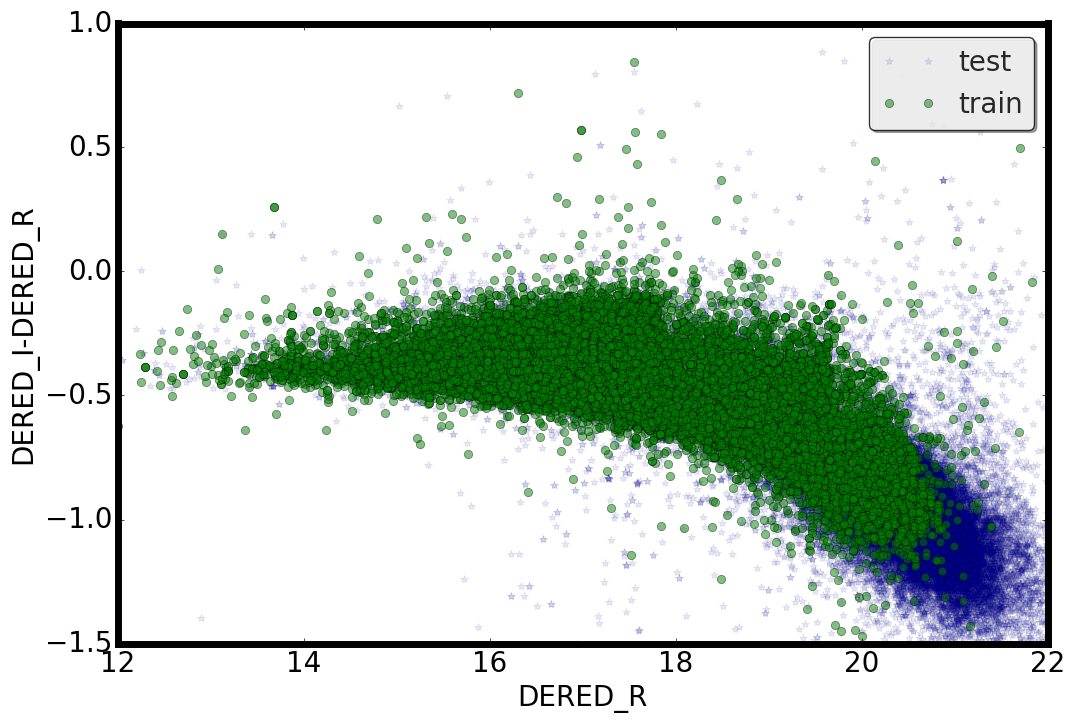

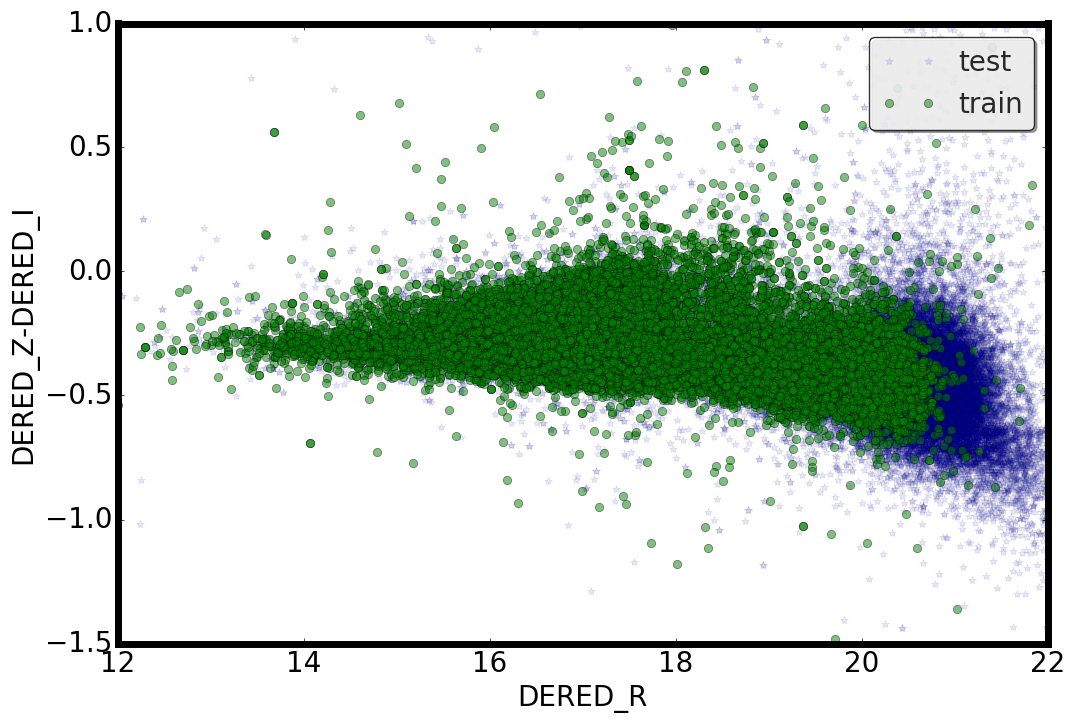

In [6]:
f = plt.figure()
plt.plot(dtest['DERED_R'], dtest['SPEC_Z'],'*', alpha=0.1, label='test')
plt.plot(dtrain['DERED_R'], dtrain['SPEC_Z'], 'o', alpha=0.5, label='train')
plt.legend(loc=2)
plt.xlabel('DERED_R')
plt.ylabel('SPEC_Z redshift')
plt.xlim(12, 22)
plt.ylim(-0.05, 1)

bn = np.linspace(15, 25, 30)
for i in ['DERED_R', 'DERED_I', 'DERED_Z']: 
    f = plt.figure()
    plt.hist(dtrain[i], bins=bn, normed=True, alpha=0.5, label='train')
    plt.hist(dtest[i], bins=bn, normed=True, alpha=0.5, label='test')
    plt.legend()
    plt.xlabel(i)
    
mgs = ['DERED_R', 'DERED_I', 'DERED_Z']
for i in [1, 2]: 
    f = plt.figure()
    plt.plot(dtest['DERED_R'], dtest[mgs[i]] -  dtest[mgs[i-1]],'*', alpha=0.1, label='test')
    plt.plot(dtrain['DERED_R'], dtrain[mgs[i]] -  dtrain[mgs[i-1]], 'o', alpha=0.5, label='train')
    plt.legend()
    plt.xlabel('DERED_R')
    plt.ylabel(mgs[i] + '-' + mgs[i-1])
    plt.xlim(12, 22)
    plt.ylim(-1.5, 1)



<h4>Save the data</h4>

In [7]:
dtest.write(path +'data/SDSS_DR13_FRANKZ.test.fit')
dtrain.write(path +'data/SDSS_DR13_FRANKZ.train.fit')
#we then compress the files using bzip2

<h2>COSMOS data</h2>